#### 1. Data import and device

In [2]:
from IPython.display import display
from PIL import Image
import os
import torch
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as T
import torchvision.models as models
from pathlib import Path
from collections import Counter
import pandas as pd
import plotly.express as px
import seaborn as sns

In [ ]:
# --- config ---
ROOT = Path().resolve()
DATA_DIR = os.path.join(ROOT, "data", "archive", "Dataset")
IMG_SIZE = 224
BATCH_SIZE = 64
VAL_SPLIT = 0.2
SEED = 42
NUM_WORKERS = 2
PIN = torch.cuda.is_available()

# --- transforms ---
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

train_tf = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(0.5),
    T.RandomRotation(10),
    T.ColorJitter(0.1, 0.1, 0.05),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

val_tf = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])


def get_loaders(
        data_dir: str = DATA_DIR,
        batch_size: int = BATCH_SIZE,
        val_split: float = VAL_SPLIT,
        seed: int = SEED,
        num_workers: int = NUM_WORKERS,
        pin_memory: bool = PIN,
):
    full = torchvision.datasets.ImageFolder(root=data_dir, transform=train_tf)
    n = len(full)
    n_val = int(n * val_split)
    n_train = n - n_val

    g = torch.Generator().manual_seed(seed)
    train_set, val_set = random_split(full, [n_train, n_val], generator=g)

    # clean tf for val
    val_set.dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=val_tf)

    class_to_idx = full.class_to_idx
    idx_to_class = {v: k for k, v in class_to_idx.items()}

    train_loader = DataLoader(
        train_set, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=pin_memory, drop_last=False
    )
    val_loader = DataLoader(
        val_set, batch_size=batch_size * 2, shuffle=False,
        num_workers=num_workers, pin_memory=pin_memory, drop_last=False
    )
    return train_loader, val_loader, idx_to_class


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader, val_loader, idx_to_class = get_loaders()

xb, yb = next(iter(train_loader))


#### 2.Data visualization

show image amount, show class amount,and batch size

In [ ]:
print("Using device:", device)
print(f"Total images: {len(train_loader.dataset) + len(val_loader.dataset)}  |  "
      f"Train: {len(train_loader.dataset)}  Val: {len(val_loader.dataset)}")
print("Num classes:", len(idx_to_class))
print("Classes:", list(idx_to_class.values()))
print("Batch:", xb.shape, yb.shape)


Display the first 10 images from the dataset.

In [ ]:
dataset = train_loader.dataset
for i in range(9):
    img, label = dataset[i]
    # --- 反归一化 ---
    img = img.detach().cpu()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    if img.shape[0] == 3:
        img = img * std + mean

    # --- CHW -> HWC + 转成 0~255 uint8 ---
    img = img.permute(1, 2, 0).clamp(0, 1)  # HWC, [0,1]
    img = (img * 255).byte().numpy()  # uint8 array

    # --- 转 PIL 图像并显示 ---
    img = Image.fromarray(img)
    display(img)

    real_class_name = idx_to_class[label]
    print(real_class_name, end="")

Count images per class to check class balance.

In [ ]:
# labels = []
# for img, label in dataset:
#     labels.append(idx_to_class[label])

labels = [idx_to_class[label] for label in train_loader.dataset.dataset.targets]
print(Counter(labels))

In [ ]:
count = Counter(labels)

# 构造 DataFrame（关键在这里）
df = pd.DataFrame(sorted(count.items(), key=lambda x: x[0]), columns=["class", "count"])

# 直接可视化（Jupyter里自动显示，不会卡）
fig = px.bar(df, x="class", y="count", title="Class Distribution", text="count")
fig.update_traces(textposition="outside", cliponaxis=False)
fig.update_layout(xaxis_tickangle=-45)

display(fig)

#### 3. Data cleaning

In [ ]:
### 3. Data cleaning
import shutil
from PIL import Image, UnidentifiedImageError
import numpy as np
from tqdm import tqdm

CLEAN_DIR = os.path.join(ROOT, "data", "clean")  # 输出干净数据的镜像目录
MIN_SIDE = 64  # 过小图片阈值（任一边 < MIN_SIDE 则剔除）
ALLOW_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}  # 可自行增减
DO_DEDUP = True  # 是否进行感知哈希去重
DEDUPE_SCOPE = "global"  # "class" 仅类内去重, "global" 全局去重


def _safe_ext(p: Path) -> str:
    return p.suffix.lower()


def _is_image_file(p: Path) -> bool:
    return _safe_ext(p) in ALLOW_EXTS


def _pil_open_rgb(path: str):
    """打开并转 RGB，返回 (img, w, h)。失败抛异常。"""
    with Image.open(path) as im:
        im.load()
        im = im.convert("RGB")
        w, h = im.size
    return im, w, h


def _ahash(img: Image.Image, hash_size: int = 8) -> int:
    """简单 aHash：缩放灰度 -> 与均值比较 -> bit 布尔阵列 -> 整数"""
    g = img.convert("L").resize((hash_size, hash_size), Image.Resampling.BILINEAR)
    arr = np.asarray(g, dtype=np.float32)
    mean = arr.mean()
    bits = (arr >= mean).astype(np.uint8).ravel()
    # 将 64bit 布尔转整数
    h = 0
    for b in bits:
        h = (h << 1) | int(b)
    return h


def _iter_class_images(root_dir: str):
    """遍历 ImageFolder 结构：root/class_x/xxx.jpg -> 产出 (class_name, path)"""
    root = Path(root_dir)
    for cls_dir in sorted([d for d in root.iterdir() if d.is_dir()]):
        cls = cls_dir.name
        for p in cls_dir.rglob("*"):
            if p.is_file() and _is_image_file(p):
                yield cls, p


def scan_and_clean(
        src_dir: str = DATA_DIR,
        dst_dir: str = CLEAN_DIR,
        min_side: int = MIN_SIDE,
        do_dedup: bool = DO_DEDUP,
        dedupe_scope: str = DEDUPE_SCOPE,
):
    """
    扫描 src_dir -> 清洗 -> 拷贝到 dst_dir。返回清洗统计与重复信息。
    """
    # 清空/重建输出目录
    if os.path.exists(dst_dir):
        shutil.rmtree(dst_dir)
    os.makedirs(dst_dir, exist_ok=True)

    stats = {
        "total_found": 0,
        "copied": 0,
        "skipped_unreadable": 0,
        "skipped_too_small": 0,
        "skipped_other": 0,
        "by_class": {},  # {class: count}
    }

    # 去重缓存
    seen_hashes_global = {}
    seen_hashes_per_class = {}

    problems = {
        "unreadable": [],  # (class, path)
        "too_small": [],  # (class, path, size)
        "dup_same_class": [],  # (class, path, dup_of_path)
        "dup_cross_class": [],  # (class, path, dup_class, dup_of_path)
        "bad_ext": [],  # (class, path)
    }

    for cls, path in tqdm(list(_iter_class_images(src_dir)), desc="Scanning"):
        stats["total_found"] += 1
        # 打开图片 & 基本过滤
        try:
            img, w, h = _pil_open_rgb(str(path))
        except (UnidentifiedImageError, OSError) as e:
            stats["skipped_unreadable"] += 1
            problems["unreadable"].append((cls, str(path)))
            continue

        if min(w, h) < min_side:
            stats["skipped_too_small"] += 1
            problems["too_small"].append((cls, str(path), (w, h)))
            continue

        # 扩展名检查（允许但会统一保存为 .jpg）
        if _safe_ext(path) not in ALLOW_EXTS:
            problems["bad_ext"].append((cls, str(path)))

        # 去重（可选）
        is_dup = False
        dup_of = None
        if do_dedup:
            hval = _ahash(img)  # int
            if dedupe_scope == "class":
                seen_hashes_per_class.setdefault(cls, {})
                if hval in seen_hashes_per_class[cls]:
                    is_dup = True
                    dup_of = seen_hashes_per_class[cls][hval]
                    problems["dup_same_class"].append((cls, str(path), dup_of))
                else:
                    seen_hashes_per_class[cls][hval] = str(path)
            else:  # global
                if hval in seen_hashes_global:
                    prev_cls, prev_path = seen_hashes_global[hval]
                    is_dup = True
                    dup_of = prev_path
                    if prev_cls == cls:
                        problems["dup_same_class"].append((cls, str(path), dup_of))
                    else:
                        problems["dup_cross_class"].append((cls, str(path), prev_cls, dup_of))
                else:
                    seen_hashes_global[hval] = (cls, str(path))

        if is_dup:
            # 直接跳过重复项
            stats["skipped_other"] += 1
            continue

        # 保存为统一 jpg 到 dst_dir/class/filename.jpg（保留相对结构）
        out_cls_dir = Path(dst_dir) / cls
        out_cls_dir.mkdir(parents=True, exist_ok=True)

        # 文件名去除原扩展，统一 .jpg
        stem = path.stem
        out_path = out_cls_dir / f"{stem}.jpg"

        # 若重名则添加计数后缀
        suf_idx = 1
        while out_path.exists():
            out_path = out_cls_dir / f"{stem}__{suf_idx}.jpg"
            suf_idx += 1

        img.save(out_path, format="JPEG", quality=95)
        stats["copied"] += 1
        stats["by_class"][cls] = stats["by_class"].get(cls, 0) + 1

    return stats, problems


stats, problems = scan_and_clean()
print("=== Clean Summary ===")
print(stats)
print("Unreadable:", len(problems["unreadable"]),
      "| Too small:", len(problems["too_small"]),
      "| Dup(same class):", len(problems["dup_same_class"]),
      "| Dup(cross class):", len(problems["dup_cross_class"]))


In [ ]:
### 3.1 Inspect issues & class distribution after cleaning
from collections import Counter
import pandas as pd
import plotly.express as px


def _preview_list(name, items, k=5):
    print(f"\n-- {name} (showing up to {k}) --")
    for row in items[:k]:
        print(row)


_preview_list("unreadable", problems["unreadable"])
_preview_list("too_small", problems["too_small"])
_preview_list("dup_same_class", problems["dup_same_class"])
_preview_list("dup_cross_class", problems["dup_cross_class"])

# 清洗后类分布
clean_counts = Counter()
for cls, p in _iter_class_images(CLEAN_DIR):
    clean_counts[cls] += 1

df_clean = pd.DataFrame(sorted(clean_counts.items(), key=lambda x: x[0]), columns=["class", "count"])
fig = px.bar(df_clean, x="class", y="count", title="Class Distribution (CLEANED)", text="count")
fig.update_traces(textposition="outside", cliponaxis=False)
fig.update_layout(xaxis_tickangle=-45)
display(fig)

print("Total after cleaning:", sum(clean_counts.values()))


In [ ]:
### 3.2 Enhancement — imbalance handling, RandAugment & MixUp
from torch.utils.data import WeightedRandomSampler


# 计算类别采样权重（用于 WeightedRandomSampler）
def compute_sampler_weights(root_dir: str = CLEAN_DIR):
    class_to_idx = {}
    # 使用与 ImageFolder 相同的类别顺序
    for i, cls in enumerate(sorted([d.name for d in Path(root_dir).iterdir() if d.is_dir()])):
        class_to_idx[cls] = i

    per_class_counts = np.zeros(len(class_to_idx), dtype=np.int64)
    samples = []  # (path, class_idx)

    for cls, p in _iter_class_images(root_dir):
        ci = class_to_idx[cls]
        per_class_counts[ci] += 1
        samples.append((str(p), ci))

    # 避免除零
    per_class_counts = np.maximum(per_class_counts, 1)
    class_weights = 1.0 / per_class_counts
    weights = [class_weights[ci] for _, ci in samples]

    # 不平衡度
    imb_ratio = float(per_class_counts.max() / per_class_counts.min())
    return weights, class_to_idx, per_class_counts, imb_ratio


weights, class_to_idx_clean, per_class_counts, imb_ratio = compute_sampler_weights(CLEAN_DIR)
print("Class order:", class_to_idx_clean)
print("Counts:", per_class_counts, "| imbalance ratio (max/min):", round(imb_ratio, 3))

USE_SAMPLER = imb_ratio >= 1.5  # 阈值
print("USE_SAMPLER =", USE_SAMPLER)

# 自动拼接 RandAugment 到 train_tf
try:
    if hasattr(T, "RandAugment"):
        train_tf = T.Compose([
            T.Resize((IMG_SIZE, IMG_SIZE)),
            T.RandAugment(num_ops=2, magnitude=7),
            T.RandomHorizontalFlip(0.5),
            T.RandomRotation(10),
            T.ColorJitter(0.1, 0.1, 0.05),
            T.ToTensor(),
            T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
        ])
        print("RandAugment enabled.")
    else:
        print("RandAugment not available in this torchvision version; skipped.")
except Exception as e:
    print("Failed to enable RandAugment:", e)


# MixUp collate_fn（训练 loader 使用）
def mixup_collate_fn(batch, alpha: float = 0.2, num_classes: int = None):
    """
    batch: list of (img_tensor[C,H,W], label_idx)
    返回： (mixed_x, mixed_y_onehot) with lambda
    """
    xs, ys = zip(*batch)
    x = torch.stack(xs, dim=0)
    y = torch.tensor(ys, dtype=torch.long)

    if num_classes is None:
        num_classes = len(class_to_idx_clean)

    lam = np.random.beta(alpha, alpha) if alpha > 0.0 else 1.0
    index = torch.randperm(x.size(0))

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_onehot = torch.zeros((x.size(0), num_classes), dtype=torch.float32)
    y_onehot.scatter_(1, y.view(-1, 1), 1.0)
    y_shuffled = y[index]
    y_shuf_onehot = torch.zeros_like(y_onehot)
    y_shuf_onehot.scatter_(1, y_shuffled.view(-1, 1), 1.0)

    mixed_y = lam * y_onehot + (1 - lam) * y_shuf_onehot
    return mixed_x, mixed_y


In [ ]:
### 3.3 Rebuild loaders from CLEAN_DIR
def get_loaders_clean(
        data_dir: str = CLEAN_DIR,
        batch_size: int = BATCH_SIZE,
        val_split: float = VAL_SPLIT,
        seed: int = SEED,
        num_workers: int = NUM_WORKERS,
        pin_memory: bool = PIN,
        use_sampler: bool = USE_SAMPLER,
        use_mixup: bool = False
):
    full = torchvision.datasets.ImageFolder(root=data_dir, transform=train_tf)
    n = len(full)
    n_val = int(n * val_split)
    n_train = n - n_val

    g = torch.Generator().manual_seed(seed)
    train_set, val_set = random_split(full, [n_train, n_val], generator=g)
    # val 使用干净的 tf
    val_set.dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=val_tf)

    class_to_idx = full.class_to_idx
    idx_to_class = {v: k for k, v in class_to_idx.items()}

    # 构建采样器（仅训练集）
    sampler = None
    if use_sampler:
        # 需要把 weights 对应到 train_set 的索引
        # 重新基于 train_set 的样本路径计算权重
        train_paths = []
        train_labels = []
        for i in range(len(train_set)):
            p, y = full.samples[train_set.indices[i]]  # (path, class_idx)
            train_paths.append(p)
            train_labels.append(y)

        # 统计训练集内的 per-class counts
        tr_counts = np.zeros(len(class_to_idx), dtype=np.int64)
        for y in train_labels:
            tr_counts[y] += 1
        tr_counts = np.maximum(tr_counts, 1)
        tr_class_w = 1.0 / tr_counts
        tr_weights = torch.DoubleTensor([tr_class_w[y] for y in train_labels])
        sampler = WeightedRandomSampler(tr_weights, num_samples=len(tr_weights), replacement=True)

    train_loader = DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=(sampler is None),
        sampler=sampler,
        num_workers=num_workers,
        pin_memory=pin_memory,
        drop_last=False,
        collate_fn=(lambda b: mixup_collate_fn(b, alpha=0.2, num_classes=len(class_to_idx))) if use_mixup else None
    )
    val_loader = DataLoader(
        val_set, batch_size=batch_size * 2, shuffle=False,
        num_workers=num_workers, pin_memory=pin_memory, drop_last=False
    )
    return train_loader, val_loader, idx_to_class


# 使用 CLEAN 集合重建 DataLoader
train_loader, val_loader, idx_to_class = get_loaders_clean(
    use_sampler=USE_SAMPLER,
    use_mixup=False,  # 如需 MixUp，将其改为 True；注意你的损失函数需支持 soft labels（如 BCE 或自定义 KL/CE）
)

xb, yb = next(iter(train_loader))
print("CLEAN train batch:", xb.shape, "| y type:", type(yb))


#### 4. Model and comparison model

In [ ]:
# def build_resnet50_classifier(num_classes=23, input_shape=(224, 224, 3), base_trainable=False):
#     input = layers.Input(shape=input_shape)
#     x = preprocess_input(input)                    # preprocess
#     base = ResNet50(include_top=False, weights="imagenet", input_tensor=x)
#     base.trainable = base_trainable
#     x = layers.GlobalAveragePooling2D()(base.output)
#     x = layers.Dropout(0.2)(x)
#     out = layers.Dense(num_classes, activation="softmax")(x)
#     model = Model(input, out)
#     model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
#                   loss="sparse_categorical_crossentropy",
#                   metrics=["accuracy", tf.keras.metrics.TopKCategoricalAccuracy(k=3, name="top3")])
#     return model

def build_resnet50_classifier(num_classes=23):
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    return model


EfficientNetB0

In [ ]:
def build_efficientnet_classifier(num_classes=23):
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
    model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)
    return model


#### 5. Model training

In [ ]:
# Training hyperparameters
EPOCHS = 30
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
PATIENCE = 5  # Early stopping patience

# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on: {device}")


In [ ]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


def validate(model, loader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


In [ ]:
def train_model(model, train_loader, val_loader, epochs=EPOCHS, lr=LEARNING_RATE,
                weight_decay=WEIGHT_DECAY, patience=PATIENCE, model_name="model"):
    """Complete training loop with early stopping and checkpointing"""
    model = model.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )

    best_val_acc = 0.0
    best_epoch = 0
    epochs_no_improve = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    print(f"\nStarting training for {model_name}...")
    print("-" * 70)

    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        scheduler.step(val_loss)

        print(f"Epoch {epoch+1:2d}/{epochs} | "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc:6.2f}% | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:6.2f}%", end="")

        # Early stopping & checkpoint
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1
            epochs_no_improve = 0
            torch.save(model.state_dict(), f'best_{model_name}.pth')
            print(f" ✓ [Best: {val_acc:.2f}%]")
        else:
            epochs_no_improve += 1
            print()

        if epochs_no_improve >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            print(f"Best validation accuracy: {best_val_acc:.2f}% (epoch {best_epoch})")
            break

    # Load best weights
    model.load_state_dict(torch.load(f'best_{model_name}.pth'))
    print(f"\nTraining complete! Best model saved as 'best_{model_name}.pth'")
    print("-" * 70)
    return model, history


In [ ]:
# Train ResNet50
print("=" * 70)
print("TRAINING RESNET50")
print("=" * 70)
resnet_model = build_resnet50_classifier(num_classes=len(idx_to_class))
resnet_model, resnet_history = train_model(
    resnet_model, train_loader, val_loader,
    model_name="resnet50"
)


In [ ]:
# Train EfficientNetB0
print("\n" + "=" * 70)
print("TRAINING EFFICIENTNETB0")
print("=" * 70)
efficientnet_model = build_efficientnet_classifier(num_classes=len(idx_to_class))
efficientnet_model, efficientnet_history = train_model(
    efficientnet_model, train_loader, val_loader,
    model_name="efficientnet_b0"
)


In [ ]:
# Save models with complete metadata for future reuse
def save_model_with_metadata(model, history, model_name, num_classes, class_mapping):
    """Save model weights + training history + class mapping"""
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'history': history,
        'num_classes': num_classes,
        'class_to_idx': class_mapping,
        'model_name': model_name
    }
    torch.save(checkpoint, f'{model_name}_complete.pth')
    print(f"✓ Saved {model_name} with metadata to '{model_name}_complete.pth'")

print("\n" + "=" * 70)
print("SAVING MODELS")
print("=" * 70)

# Save both models
save_model_with_metadata(resnet_model, resnet_history, 'resnet50',
                         len(idx_to_class), train_loader.dataset.dataset.class_to_idx)
save_model_with_metadata(efficientnet_model, efficientnet_history, 'efficientnet_b0',
                         len(idx_to_class), train_loader.dataset.dataset.class_to_idx)

print("\n✓ Training complete for both models!")
print("✓ Models saved with complete metadata")
print("→ See Section 6 for detailed performance comparison and analysis")
print("→ Use ModelInference.ipynb to reload models without retraining")


#### 6. Model performance comparison & CV

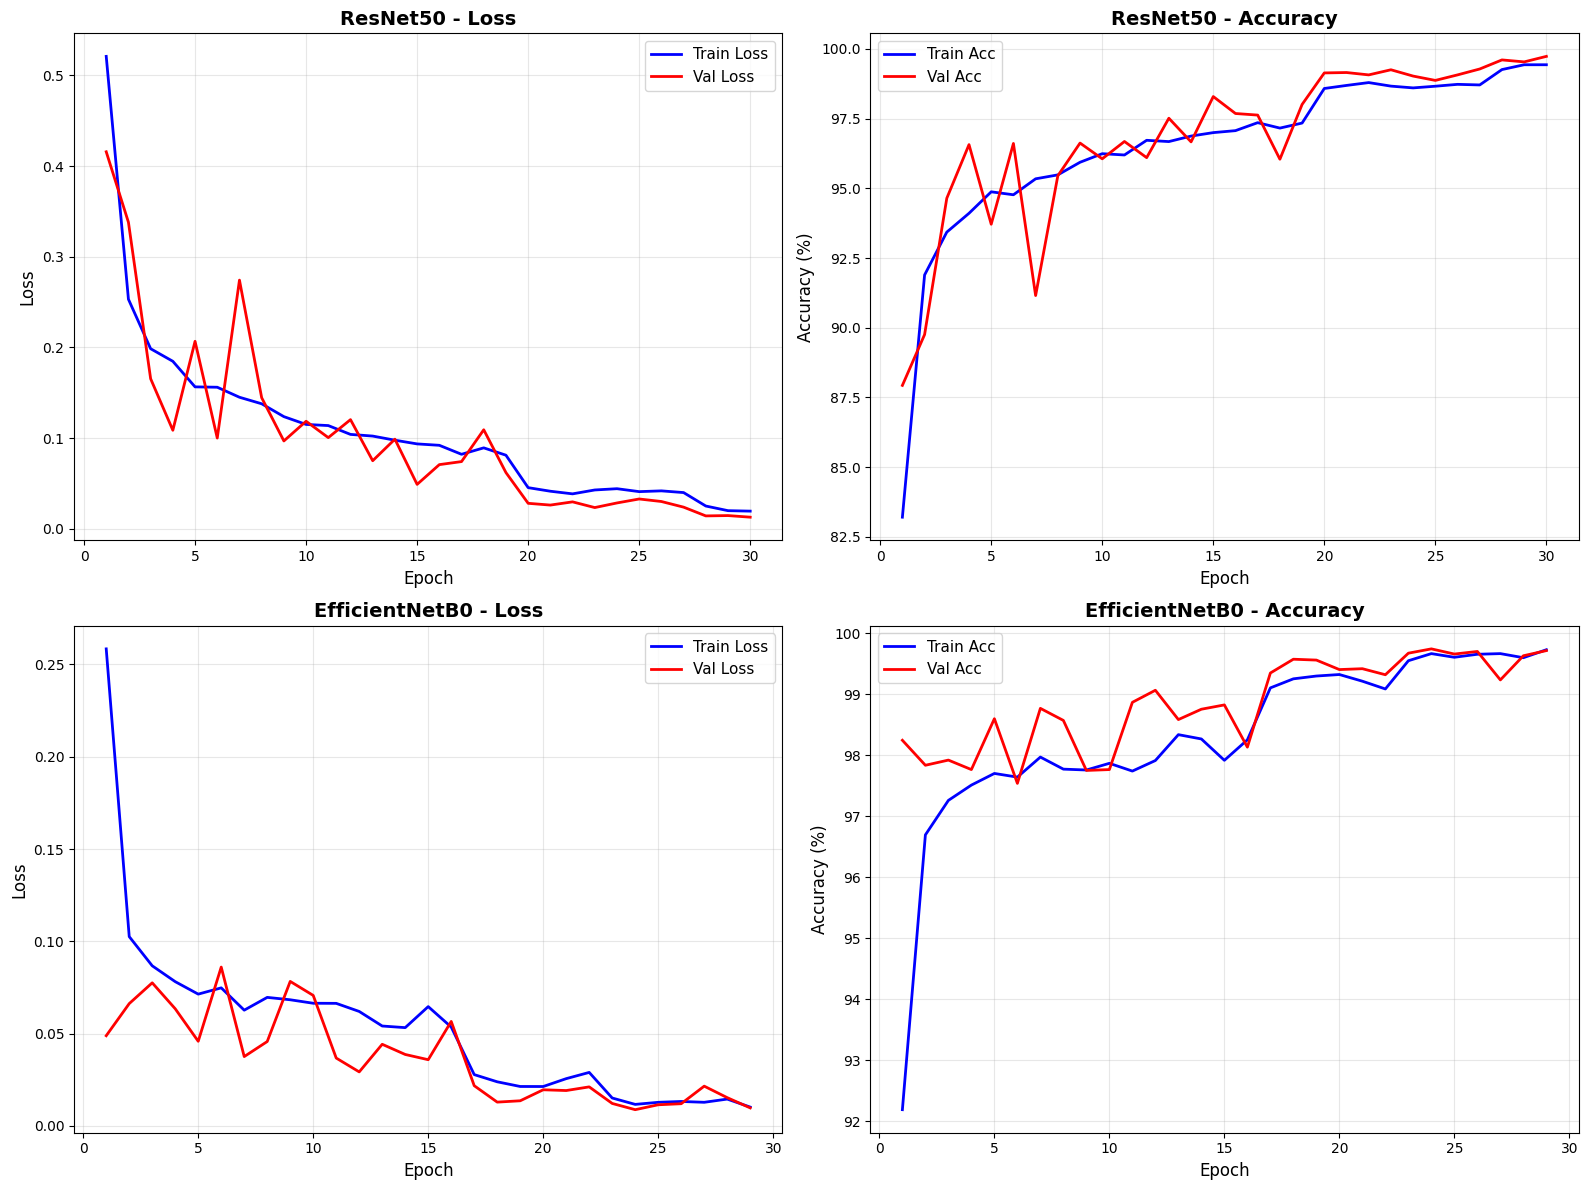

In [48]:
# 6.1 Compare training histories from both models
from matplotlib import pyplot as plt

def plot_training_histories_comparison(history1, history2, model_name1, model_name2):
    """Compare training histories of two models side by side"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    epochs1 = range(1, len(history1['train_loss']) + 1)
    epochs2 = range(1, len(history2['train_loss']) + 1)

    # Model 1 - Loss
    ax1.plot(epochs1, history1['train_loss'], 'b-', label='Train Loss', linewidth=2)
    ax1.plot(epochs1, history1['val_loss'], 'r-', label='Val Loss', linewidth=2)
    ax1.set_title(f'{model_name1} - Loss', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # Model 1 - Accuracy
    ax2.plot(epochs1, history1['train_acc'], 'b-', label='Train Acc', linewidth=2)
    ax2.plot(epochs1, history1['val_acc'], 'r-', label='Val Acc', linewidth=2)
    ax2.set_title(f'{model_name1} - Accuracy', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)

    # Model 2 - Loss
    ax3.plot(epochs2, history2['train_loss'], 'b-', label='Train Loss', linewidth=2)
    ax3.plot(epochs2, history2['val_loss'], 'r-', label='Val Loss', linewidth=2)
    ax3.set_title(f'{model_name2} - Loss', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Loss', fontsize=12)
    ax3.set_xlabel('Epoch', fontsize=12)
    ax3.legend(fontsize=11)
    ax3.grid(True, alpha=0.3)

    # Model 2 - Accuracy
    ax4.plot(epochs2, history2['train_acc'], 'b-', label='Train Acc', linewidth=2)
    ax4.plot(epochs2, history2['val_acc'], 'r-', label='Val Acc', linewidth=2)
    ax4.set_title(f'{model_name2} - Accuracy', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Accuracy (%)', fontsize=12)
    ax4.set_xlabel('Epoch', fontsize=12)
    ax4.legend(fontsize=11)
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot comparison
plot_training_histories_comparison(resnet_history, efficientnet_history, 'ResNet50', 'EfficientNetB0')


In [49]:
# 6.2 Detailed evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, top_k_accuracy_score

def evaluate_model_pytorch(model, loader, device, k=3):
    """Evaluate PyTorch model and return metrics"""
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []
    total_loss = 0.0
    correct = 0
    total = 0

    criterion = torch.nn.CrossEntropyLoss()

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = total_loss / total
    accuracy = 100. * correct / total

    # Calculate top-k accuracy
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)
    top_k_acc = top_k_accuracy_score(all_labels, all_probs, k=k) * 100

    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'top_k_accuracy': top_k_acc,
        'predictions': np.array(all_preds),
        'probabilities': all_probs,
        'labels': all_labels
    }

print("Evaluating ResNet50...")
resnet_results = evaluate_model_pytorch(resnet_model, val_loader, device, k=3)

print("Evaluating EfficientNetB0...")
efficientnet_results = evaluate_model_pytorch(efficientnet_model, val_loader, device, k=3)

# Create comparison table
results_df = pd.DataFrame({
    'Model': ['ResNet50', 'EfficientNetB0'],
    'Validation Loss': [resnet_results['loss'], efficientnet_results['loss']],
    'Validation Accuracy (%)': [resnet_results['accuracy'], efficientnet_results['accuracy']],
    'Top-3 Accuracy (%)': [resnet_results['top_k_accuracy'], efficientnet_results['top_k_accuracy']]
})

print("\n" + "=" * 70)
print("MODEL PERFORMANCE COMPARISON")
print("=" * 70)
display(results_df.style.format({
    'Validation Loss': '{:.4f}',
    'Validation Accuracy (%)': '{:.2f}',
    'Top-3 Accuracy (%)': '{:.2f}'
}).hide(axis="index"))


Evaluating ResNet50...
Evaluating EfficientNetB0...

MODEL PERFORMANCE COMPARISON


Model,Validation Loss,Validation Accuracy (%),Top-3 Accuracy (%)
ResNet50,0.0128,99.73,100.00
EfficientNetB0,0.0088,99.75,100.00



RESNET50 CLASSIFICATION REPORT
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab      1.000     1.000     1.000       410
                                 Apple___Black_rot      1.000     1.000     1.000       414
                          Apple___Cedar_apple_rust      1.000     1.000     1.000       339
                                   Apple___healthy      1.000     1.000     1.000       419
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot      0.994     0.985     0.990       340
                       Corn_(maize)___Common_rust_      1.000     0.997     0.999       362
               Corn_(maize)___Northern_Leaf_Blight      0.987     0.997     0.992       386
                            Corn_(maize)___healthy      1.000     1.000     1.000       359
                     Pepper__bell___Bacterial_spot      0.985     1.000     0.992       193
                            Pepper__bell___heal

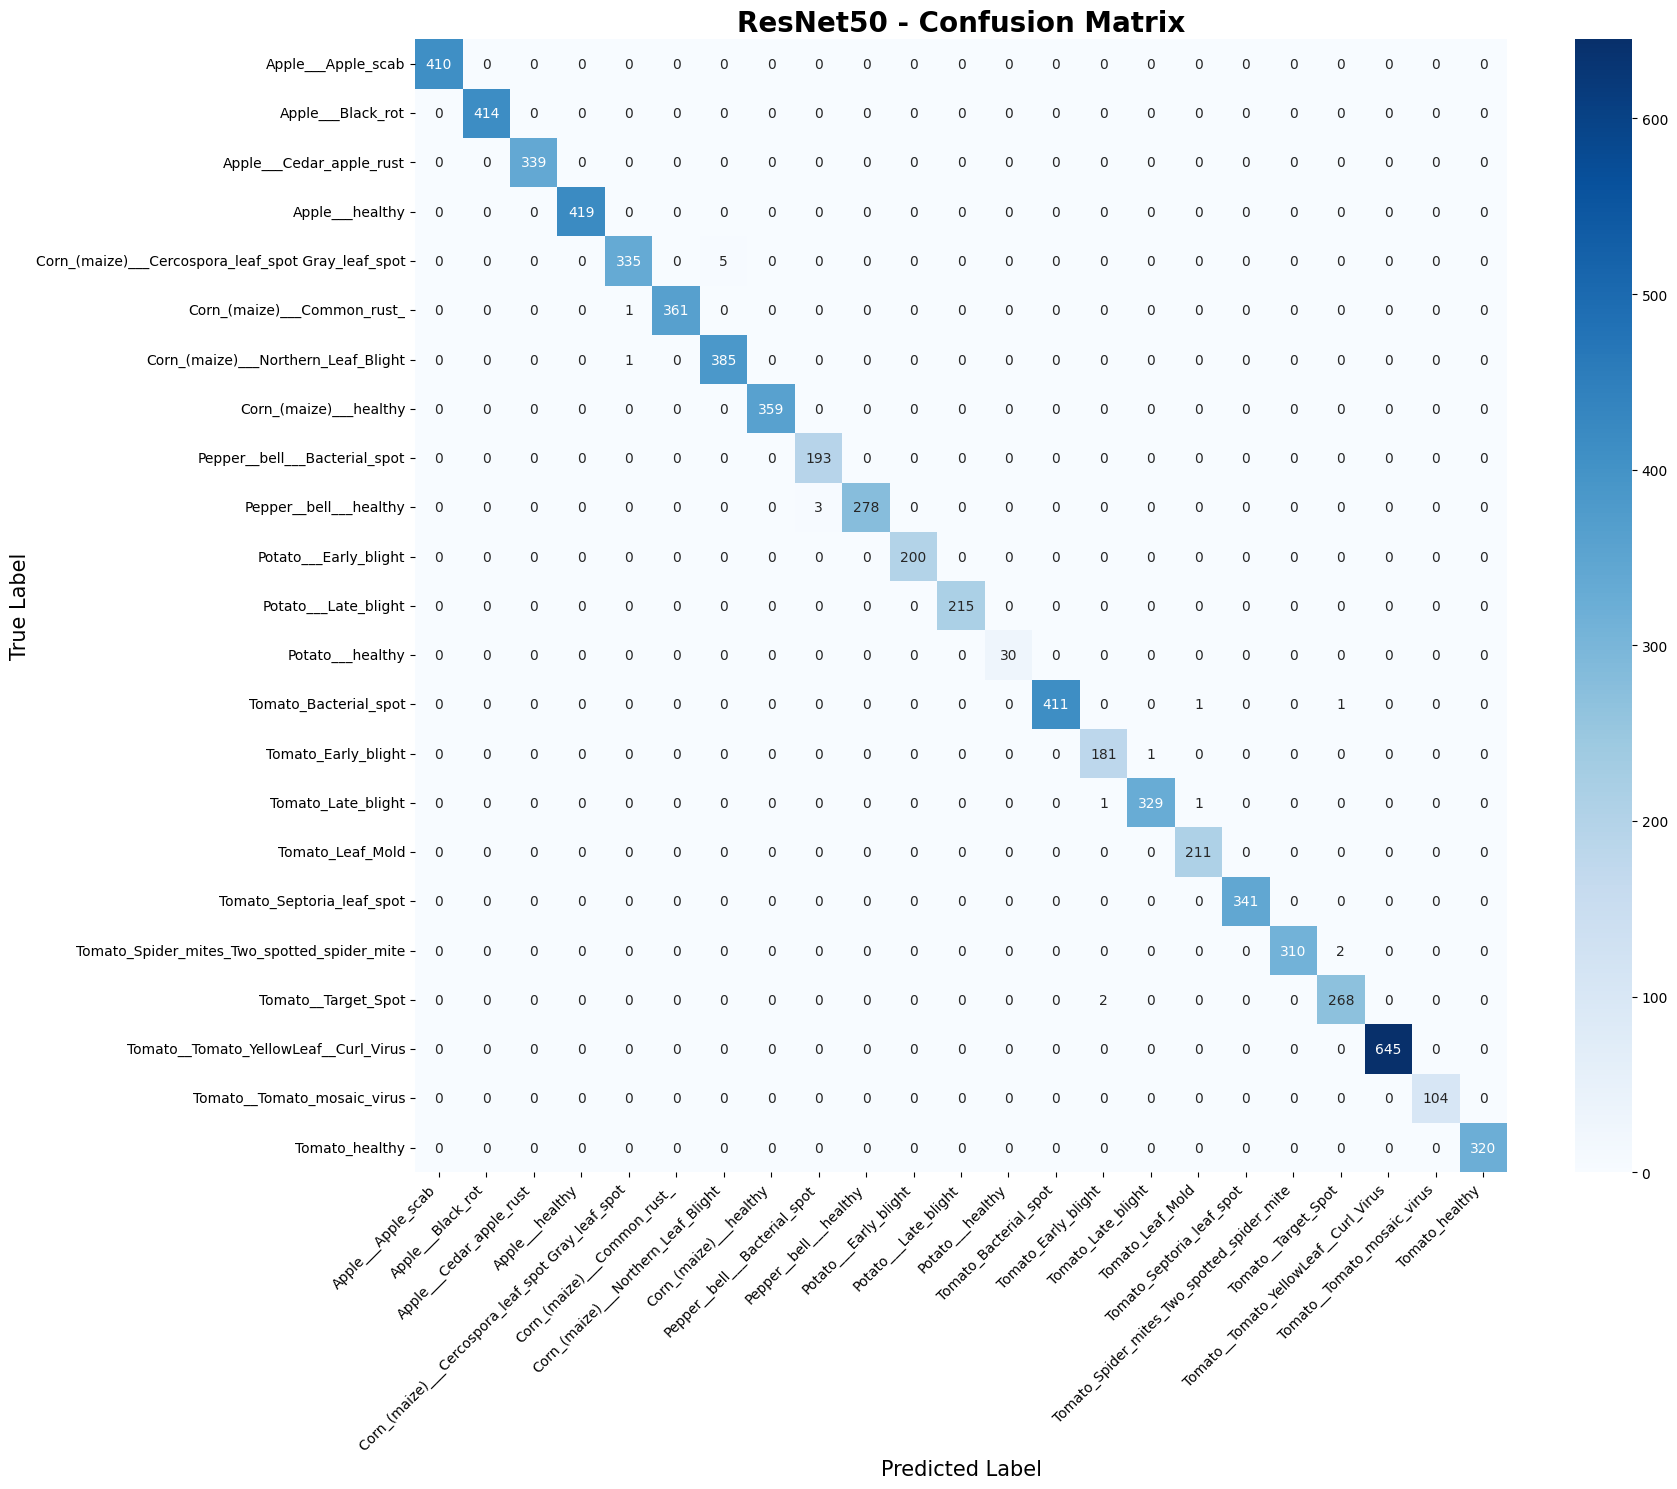

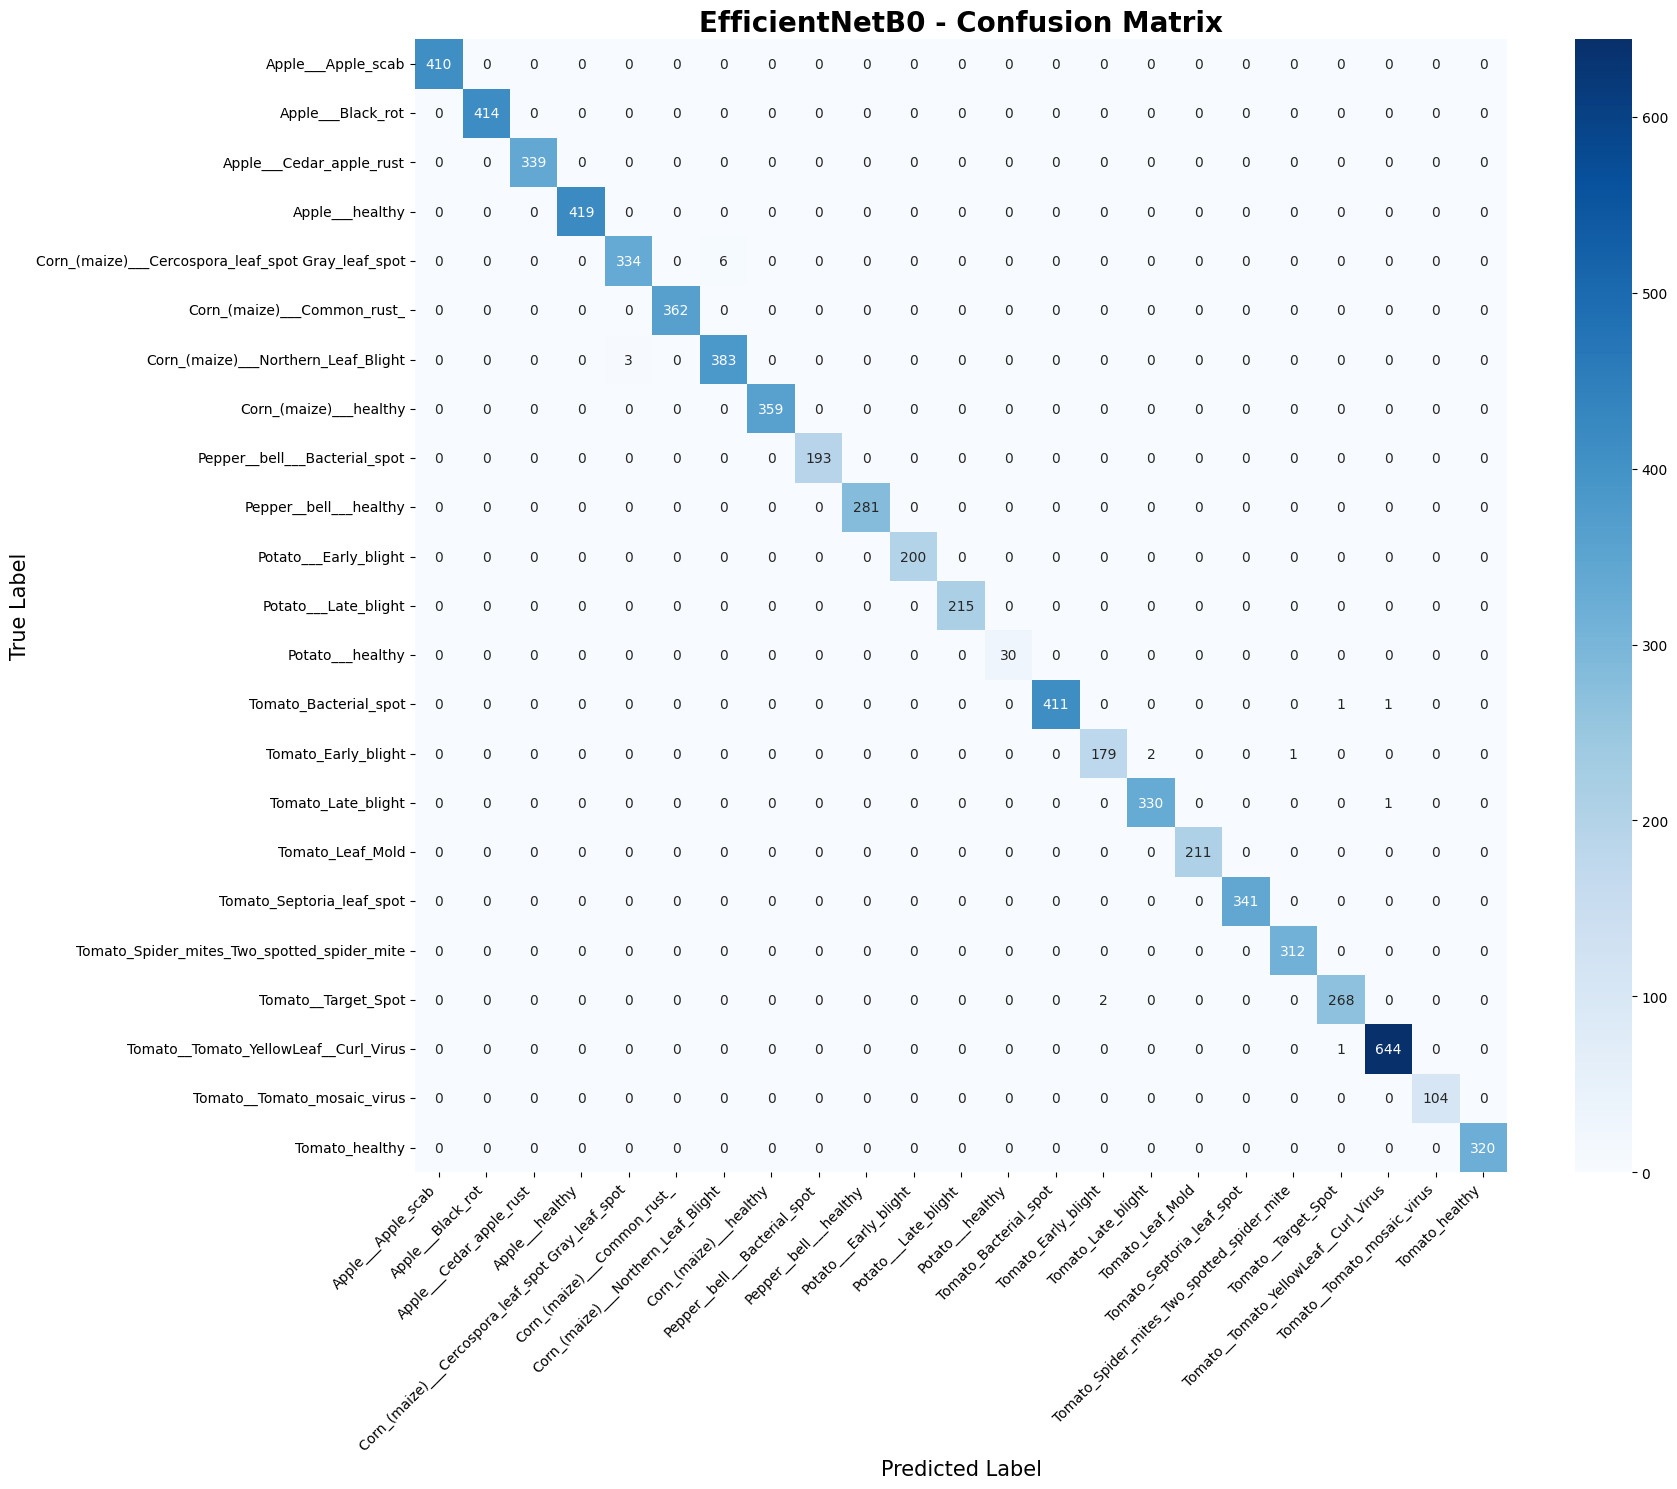

In [52]:
# 6.3 Classification reports and confusion matrices
from sklearn.metrics import classification_report, confusion_matrix

# Get class names
class_names = list(idx_to_class.values())

# Print classification reports
print("\n" + "=" * 70)
print("RESNET50 CLASSIFICATION REPORT")
print("=" * 70)
print(classification_report(resnet_results['labels'], resnet_results['predictions'],
                          target_names=class_names, digits=3))

print("\n" + "=" * 70)
print("EFFICIENTNETB0 CLASSIFICATION REPORT")
print("=" * 70)
print(classification_report(efficientnet_results['labels'], efficientnet_results['predictions'],
                          target_names=class_names, digits=3))

# Plot confusion matrices
def plot_confusion_matrix(y_true, y_pred, model_name, class_names):
    """Plot confusion matrix heatmap"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(18, 15))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} - Confusion Matrix', fontsize=20, fontweight='bold')
    plt.ylabel('True Label', fontsize=15)
    plt.xlabel('Predicted Label', fontsize=15)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Plot confusion matrices for both models
plot_confusion_matrix(resnet_results['labels'], resnet_results['predictions'],
                     'ResNet50', class_names)
plot_confusion_matrix(efficientnet_results['labels'], efficientnet_results['predictions'],
                     'EfficientNetB0', class_names)


In [ ]:
# 6.4 Cross-Validation (K-Fold)
from sklearn.model_selection import KFold

RUN_CV = True  # Set to True to run CV (takes a long time)

if RUN_CV:
    N_SPLITS = 5
    EPOCHS_PER_FOLD = 10

    print("\n" + "=" * 70)
    print(f"STARTING {N_SPLITS}-FOLD CROSS-VALIDATION")
    print("=" * 70)

    # Load full clean dataset
    clean_dataset_full = torchvision.datasets.ImageFolder(root=CLEAN_DIR, transform=train_tf)
    all_indices = np.arange(len(clean_dataset_full))

    kfold = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

    # Store results for each fold
    cv_results = {
        'ResNet50': {'loss': [], 'accuracy': [], 'top3_acc': []},
        'EfficientNetB0': {'loss': [], 'accuracy': [], 'top3_acc': []}
    }

    for fold, (train_ids, val_ids) in enumerate(kfold.split(all_indices)):
        print(f"\n{'=' * 25} FOLD {fold + 1}/{N_SPLITS} {'=' * 25}")

        # Create data subsets for this fold
        train_subset = torch.utils.data.Subset(clean_dataset_full, train_ids)

        val_dataset_fold = torchvision.datasets.ImageFolder(root=CLEAN_DIR, transform=val_tf)
        val_subset = torch.utils.data.Subset(val_dataset_fold, val_ids)

        train_loader_fold = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True,
                                      num_workers=NUM_WORKERS, pin_memory=PIN)
        val_loader_fold = DataLoader(val_subset, batch_size=BATCH_SIZE * 2, shuffle=False,
                                    num_workers=NUM_WORKERS, pin_memory=PIN)

        # Train ResNet50
        print("\nTraining ResNet50...")
        resnet_fold = build_resnet50_classifier(num_classes=len(idx_to_class))
        resnet_fold, _ = train_model(resnet_fold, train_loader_fold, val_loader_fold,
                                    epochs=EPOCHS_PER_FOLD, patience=3,
                                    model_name=f"resnet50_fold{fold+1}")

        # Evaluate ResNet50
        resnet_fold_results = evaluate_model_pytorch(resnet_fold, val_loader_fold, device)
        cv_results['ResNet50']['loss'].append(resnet_fold_results['loss'])
        cv_results['ResNet50']['accuracy'].append(resnet_fold_results['accuracy'])
        cv_results['ResNet50']['top3_acc'].append(resnet_fold_results['top_k_accuracy'])
        print(f"  ResNet50 Fold {fold + 1} - Val Acc: {resnet_fold_results['accuracy']:.2f}%")

        # Train EfficientNetB0
        print("\nTraining EfficientNetB0...")
        efficientnet_fold = build_efficientnet_classifier(num_classes=len(idx_to_class))
        efficientnet_fold, _ = train_model(efficientnet_fold, train_loader_fold, val_loader_fold,
                                          epochs=EPOCHS_PER_FOLD, patience=3,
                                          model_name=f"efficientnet_fold{fold+1}")

        # Evaluate EfficientNetB0
        eff_fold_results = evaluate_model_pytorch(efficientnet_fold, val_loader_fold, device)
        cv_results['EfficientNetB0']['loss'].append(eff_fold_results['loss'])
        cv_results['EfficientNetB0']['accuracy'].append(eff_fold_results['accuracy'])
        cv_results['EfficientNetB0']['top3_acc'].append(eff_fold_results['top_k_accuracy'])
        print(f"  EfficientNetB0 Fold {fold + 1} - Val Acc: {eff_fold_results['accuracy']:.2f}%")

    # Display final CV results
    print("\n" + "=" * 70)
    print("CROSS-VALIDATION FINAL RESULTS")
    print("=" * 70)

    cv_summary = pd.DataFrame({
        'Fold': list(range(1, N_SPLITS + 1)),
        'ResNet50 Acc (%)': cv_results['ResNet50']['accuracy'],
        'EfficientNetB0 Acc (%)': cv_results['EfficientNetB0']['accuracy'],
        'ResNet50 Loss': cv_results['ResNet50']['loss'],
        'EfficientNetB0 Loss': cv_results['EfficientNetB0']['loss']
    })

    print("\nPer-Fold Results:")
    display(cv_summary.style.format({
        'ResNet50 Acc (%)': '{:.2f}',
        'EfficientNetB0 Acc (%)': '{:.2f}',
        'ResNet50 Loss': '{:.4f}',
        'EfficientNetB0 Loss': '{:.4f}'
    }))

    # Average results
    avg_results = pd.DataFrame({
        'Model': ['ResNet50', 'EfficientNetB0'],
        'Avg Accuracy (%)': [
            np.mean(cv_results['ResNet50']['accuracy']),
            np.mean(cv_results['EfficientNetB0']['accuracy'])
        ],
        'Std Accuracy': [
            np.std(cv_results['ResNet50']['accuracy']),
            np.std(cv_results['EfficientNetB0']['accuracy'])
        ],
        'Avg Loss': [
            np.mean(cv_results['ResNet50']['loss']),
            np.mean(cv_results['EfficientNetB0']['loss'])
        ],
        'Avg Top-3 Acc (%)': [
            np.mean(cv_results['ResNet50']['top3_acc']),
            np.mean(cv_results['EfficientNetB0']['top3_acc'])
        ]
    })

    print("\nAverage Across All Folds:")
    display(avg_results.style.format({
        'Avg Accuracy (%)': '{:.2f}',
        'Std Accuracy': '{:.2f}',
        'Avg Loss': '{:.4f}',
        'Avg Top-3 Acc (%)': '{:.2f}'
    }).hide(axis="index"))

else:
    print("\n" + "=" * 70)
    print("Cross-Validation skipped (RUN_CV=False)")
    print("Set RUN_CV=True to run K-Fold Cross-Validation")
    print("=" * 70)


#### 7. Export Notebook to HTML

In [3]:
# Export this notebook with all outputs to HTML for reporting
import subprocess
import sys
from datetime import datetime

notebook_name = "FirstDraft.ipynb"
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_html = f"PlantDisease_Training_Report_{timestamp}.html"

try:
    # Use nbconvert to export
    result = subprocess.run([
        sys.executable, "-m", "jupyter", "nbconvert",
        "--to", "html",
        "--output", output_html,
        notebook_name
    ], capture_output=True, text=True)

    if result.returncode == 0:
        print("\n" + "="*70)
        print("✓ NOTEBOOK EXPORTED SUCCESSFULLY")
        print("="*70)
        print(f"\nHTML Report: {output_html}")
        print(f"Location: {Path(output_html).absolute()}")
        print("\nThis report includes:")
        print("  • Data cleaning statistics")
        print("  • Training curves for both models")
        print("  • Performance metrics and comparisons")
        print("  • Confusion matrices")
        print("  • Classification reports")
    else:
        print("\nError exporting notebook:")
        print(result.stderr)
        print("\nTry installing nbconvert: pip install nbconvert")
except FileNotFoundError:
    print("\nJupyter nbconvert not found.")
    print("Install it with: pip install nbconvert")
except Exception as e:
    print(f"\nError: {e}")
    print("\nAlternatively, export manually via: File > Download as > HTML")



✓ NOTEBOOK EXPORTED SUCCESSFULLY

HTML Report: PlantDisease_Training_Report_20251113_055125.html
Location: Q:\Users\zgl-7\Source\Repos\DS3000-25fall\PlantDisease_Training_Report_20251113_055125.html

This report includes:
  • Data cleaning statistics
  • Training curves for both models
  • Performance metrics and comparisons
  • Confusion matrices
  • Classification reports
